Binôme : Ahmed Tidiane BALDÉ & Bochra DOUIDI


# TP 3: Uncertainty Applications

This last lab session will focus on applications based on uncertainty estimation. We will first use MC Dropout variational inference to qualitatively evaluate the most uncertain images according to the mode. Then, we'll move to 2 examples where good uncertainty estimation is crucial : failure prediction and out-of-distribution detection.

**Goal**: Take hand on applying uncertainty estimation for failure prediction and out-of-distribution detection

**Requirements**: 
- Pytorch library:
`pip install torch torchvision`

NB: if you don't have root access on the computer, add `--user` to install the library locally.

In [0]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score
from IPython import display
from tqdm.autonotebook import tqdm
from matplotlib.pyplot import imread
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torch.utils.data.dataloader import DataLoader
from torchvision import datasets

use_cuda = True
device = torch.device("cuda" if use_cuda else "cpu")
kwargs = {'num_workers': 4, 'pin_memory': True} if use_cuda else {}

## Part I: MC Dropout on MNIST

By appling MC Dropout variational inference method, we're interested to obtain an uncertainty measure which can be use to spot the most uncertain images in our dataset.

In [0]:
# Load MNIST dataset
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(), 
                                            torchvision.transforms.Normalize((0.1307,),(0.3081,))])
train_dataset = datasets.MNIST('data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST('data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, **kwargs)
test_loader = DataLoader(test_dataset, batch_size=128, **kwargs)

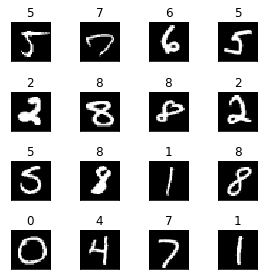

In [0]:
# Visualize some images
images, labels = next(iter(train_loader))
fig, axes = plt.subplots(nrows=4, ncols=4)
for i, (image, label) in enumerate(zip(images, labels)):
    if i >= 16:
        break
    axes[i // 4][i % 4].imshow(images[i][0], cmap='gray')
    axes[i // 4][i % 4].set_title(f"{label}")
    axes[i // 4][i % 4].set_xticks([])
    axes[i // 4][i % 4].set_yticks([])
fig.set_size_inches(4, 4)
fig.tight_layout()

**Question 1.1: Implement a LeNet3-style neural network in the following code**

(LeNet3 consists of a first convolutional layer with out_features=32, a second convolutional layer with out_features=64, both equipped with a kernel size of 3. Then, apply a Maxpooling of size 2. After flattening, add 2 linear layers whose hidden size is 128. Dropout layers are located before each one of them, first one with p=0.25, second one p=0.50)

In [0]:
#TO DO: Code a LeNet3-style neural network. Be careful, the dropout layer should be also activated 
#during test time.
#(Hint: we may want to look out at F.dropout())

class LeNet3(nn.Module):
    def __init__(self, n_classes=10):
        super().__init__()       
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )

        self.fc1 = nn.Linear(64 * 12 * 12, 128)
        self.fc2 = nn.Linear(128, n_classes)
        
    def forward(self, x):
        x = x.to(device)
        output = self.conv_layers(x)
        output = output.view(x.size(0), -1)
        output = F.relu(self.fc1(F.dropout(output, p=0.25, training=True)))
        output = self.fc2(F.dropout(output, p=0.5, training=True))
        return output

In [0]:
lenet = LeNet3(n_classes=10).to(device)
lenet.train()
optim_mcdropout = torch.optim.SGD(lenet.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)

In [0]:
criterion = nn.CrossEntropyLoss()

**Question 1.2:  Train LeNet for 20 epochs**

In [0]:
# If you already train your model, you can load it instead using :
lenet.load_state_dict(torch.load('lenet_final.cpkt'))

<All keys matched successfully>

In [0]:
#TO DO: Train LeNet3 for 20 epochs. You should approach >99% accuracy on train set
# NB: as the training is long, you may want to save your model after training in case your computer crash
# torch.save(lenet.state_dict(), 'lenet_final.cpkt')
nb_epochs = 20
for epoch in range(nb_epochs):
    for i, (images, targets) in enumerate(train_loader):
        optim_mcdropout.zero_grad()
        output = lenet.forward(images)
        targets = targets.to(device)
        loss = criterion(output, targets)
        loss.backward()
        optim_mcdropout.step()
        
        if epoch%1 == 0 and i==len(train_loader)-1:
            pred = torch.argmax(output, dim=1).to(device)
            print(f'Train set accuracy = {float((pred == targets).sum())/len(pred):.2%}')
        
torch.save(lenet.state_dict(), 'lenet_final.cpkt')

In classification, there exists a few methods to compute uncertainty estimates:
- **var-ratios**: sample a label from the softmax probabilities at the end of each stochastic forward pass, take the most frequent label then compute 
$$ \text{variation-ratio}[x] = 1 - \frac{f_x}{T} $$ 
where $f_x$ is the frequency of the chosen label and $T$ the number of pass.
- **entropy**: captures the average amount of information contained in the predictive distribution. 
$$ \mathcal{H}[y \vert x, \mathcal{D}] = - \sum_c \Big ( \frac{1}{T} \sum_t p(y=c \vert x, w_t) \Big ) \log \Big ( \frac{1}{T} \sum_t p(y=c \vert x, w_t) \Big )$$
- **mutual information** : maximise the mutual informations are points on which the model is uncertain on average
$$ \mathcal{I}[y,w \vert x, \mathcal{D}] = \mathcal{H}[y \vert x, \mathcal{D}]+ \frac{1}{T} \sum_{c,t} p(y=c \vert x, w_t) \log p(y=c \vert x, w_t) $$

**Question 1.3: Implement var-ratios, entropy and mutual information metrics as uncertainty estimates in the following function**

In [0]:
# Predicting test function
# TO DO: implement mutual information as uncertainty estimates 
# (Verify here that your model achieves also >99% accuracy on test set)

def predict_test_set(model, test_loader, mode='mcp', s=100, temp=5, epsilon=0.0006, verbose=True):
    """Predict on a test set given a model and a chosen method to compute uncertainty estimate
    (mcp, MC-dropout with var-ratios, entropy or, mutual information and ODIN)

    Args:
      model: (nn.Module) a trained model
      test_loader: (torch.DataLoader) a Pytorch dataloader based on a dataset
      mode: (str) chosen uncertainty estimate method (mcp, var-ratios, entropy, mi, odin)
      s: (int) number of samples in MCDropout
      temp: (int, optional) value of T for temperature scaling in ODIN
      epsilon: (float, optional) value of epsilon for inverse adversarial perturbation in ODIN
      verbose: (bool, optional) printing progress bar when predicting   
      
    Returns:
      pred: (tensor) class predictions by the model
      labels: (tensor) true labels of the given dataset
      uncertainties: (tensor) uncertainty estimates of the given dataset
      errors: (tensor) 0/1 vector whether the model wrongly predicted a sample
      hists : (array) number of occurences by class in each sample fo the given dataset, only with MCDropout
      mc_samples: (tensor) prediction matrix for s=100 samples, only with MCDropout
    """

    model.eval()
    pred, uncertainties, labels, errors  = [], [], [], []
    mc_samples, hists = [], []
    
    loop = tqdm(test_loader, disable=not verbose)
    for images, targets in loop:
        images, targets = images.to(device), targets.to(device)        
        if mode in ['mcp','odin']:
            model.training = False
            
            if mode=='mcp':
                with torch.no_grad():
                    output = model(images)
            
            elif mode=='odin':
                outputs = torch.zeros(images.shape[0], s, 10)
                for i in range(s):
                    with torch.no_grad():
                        outputs[:, i] = model(images)
                
                # =============================> 
                # To do question 3.3 : implement ODIN method
                
                # <======================= 
                # end to do   question 3.3  
    
            confidence, mean_pred = F.softmax(output, dim=1).max(dim=1, keepdim=True)
            confidence = confidence.detach().to('cpu').numpy()
            
        elif mode in ['var-ratios', 'entropy', 'mi']:
            model.training = True
            outputs = torch.zeros(images.shape[0], s, 10)
            for i in range(s):
                with torch.no_grad():
                    outputs[:,i] = model(images)
            mc_probs = F.softmax(outputs, dim=2)
            predicted_class = mc_probs.max(dim=2)[1]
            mean_pred = mc_probs.mean(1).max(dim=1, keepdim=True)[1]
            mc_samples.extend(mc_probs)
            hist = np.array([np.histogram(predicted_class[i,:], range=(0,10))[0]  
                              for i in range(predicted_class.shape[0])])
            hists.extend(hist)
  
            # =============================> 
            # To do : implement var-ratios, entropy and mutual_information metrics

            if mode=='var-ratios':
                # You may want to use the hist variable here
                confidence = (1 - hist.max(1)/s)
            elif mode=='entropy':
                confidence = (-mc_probs.mean(1) * np.log(mc_probs.mean(1))).sum(1)
            elif mode=='mi':
                #from IPython.core.debugger import set_trace
                #set_trace()
                confidence = (-mc_probs.mean(1) * np.log(mc_probs.mean(1))).sum(1) + (mc_probs * np.log(mc_probs)).sum(2).mean(1)
            # <======================= 
            # end to do

        pred.extend(mean_pred)
        labels.extend(targets)
        uncertainties.extend(confidence)
        errors.extend(mean_pred.to(device)!=targets.view_as(mean_pred))

    pred = np.reshape(pred, newshape=(len(pred), -1)).flatten()
    labels = np.reshape(labels, newshape=(len(labels), -1)).flatten()
    uncertainties = np.reshape(uncertainties, newshape=(len(uncertainties), -1)).flatten()
    errors = torch.cat(errors).detach().to('cpu').numpy()

    if mode in ['var-ratios', 'entropy', 'mi']:
        hists = np.reshape(hists, newshape=(len(hists), -1))

    print(f'Test set accuracy = {(pred == labels).sum()/len(pred):.2%}')
    
    return pred, labels, uncertainties, errors, hists, mc_samples

In [0]:
# Predicting along with var-ratios uncertainty estimates
pred_var, labels, uncertainty_var, errors_var, \
    hists, mc_samples = predict_test_set(lenet, test_loader, mode='var-ratios')

Test set accuracy = 99.24%


In [0]:
# Useful function
def plot_predicted_images(selected_idx, images, pred, labels, uncertainties, hists, mc_samples):
    """ Plot predicted images along with mean-pred probabilities histogram, maxprob frequencies and some class histograms
    across sampliong
    
    Args:
      selected_ix: (array) chosen index in the uncertainties tensor
      images: (tensor) images from the test set
      pred: (tensor) class predictions by the model
      labels: (tensor) true labels of the given dataset
      uncertainties: (tensor) uncertainty estimates of the given dataset
      errors: (tensor) 0/1 vector whether the model wrongly predicted a sample
      hists : (array) number of occurences by class in each sample fo the given dataset, only with MCDropout
      mc_samples: (tensor) prediction matrix for s=100 samples, only with MCDropout
      
    Returns:
        None
    """
    plt.figure(figsize=(15,10))

    for i, idx in enumerate(selected_idx):   
        # Plot original image
        plt.subplot(5,6,1+6*i)
        plt.axis('off')
        plt.title(f'mut-inf={uncertainties[idx]:.3f}, \n gt={labels[idx]}, pred={pred[idx]}')
        plt.imshow(images[idx], cmap='gray')

        # Plot mean probabilities
        plt.subplot(5,6,1+6*i+1)
        plt.title('Mean probs')
        plt.bar(range(10), mc_samples[idx].mean(0))
        plt.xticks(range(10))

        # Plot frequencies
        plt.subplot(5,6,1+6*i+2)
        plt.title('Maxprob frequencies')
        plt.bar(range(10), hists[idx])
        plt.xticks(range(10))

        # Plot probs frequency for specific class
        list_plotprobs = [hists[idx].argsort()[-1], hists[idx].argsort()[-2], hists[idx].argsort()[-4]]
        ymax = max([max(np.histogram(mc_samples[idx][:,c])[0]) for c in list_plotprobs])
        for j, c in enumerate(list_plotprobs):
            plt.subplot(5,6,1+6*i+(3+j))
            plt.title(f'Samples probs of class {c}')
            plt.hist(mc_samples[idx][:,c], bins=np.arange(0,1.1,0.1))
            plt.ylim(0,np.ceil(ymax/10)*10)
            plt.xticks(np.arange(0,1,0.1), rotation=60)

    plt.tight_layout()
    plt.show()

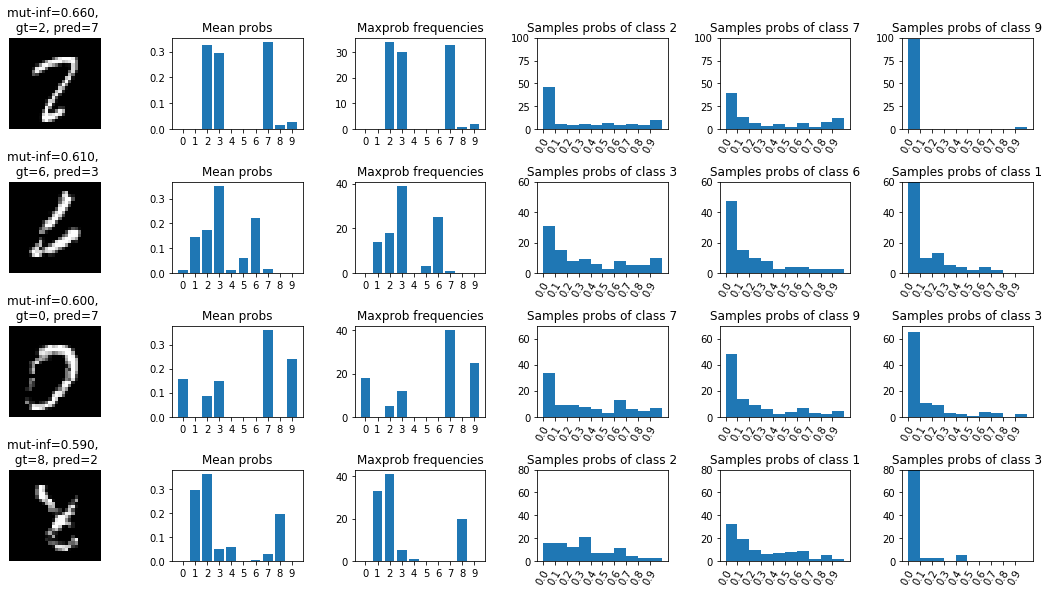

In [0]:
# Plotting the top-4 most uncertain images along with their var-ratios value
top4_uncertain_samples = uncertainty_var.argsort()[-4:][::-1]
plot_predicted_images(top4_uncertain_samples, test_loader.dataset.data, pred_var, labels, uncertainty_var, hists, mc_samples)

**Question 1.4: Using previous function and compare with some random images along with their mutual information value, their ground-truth class and prediction class. How do their probs distribution compare to the previous top uncertain images?**

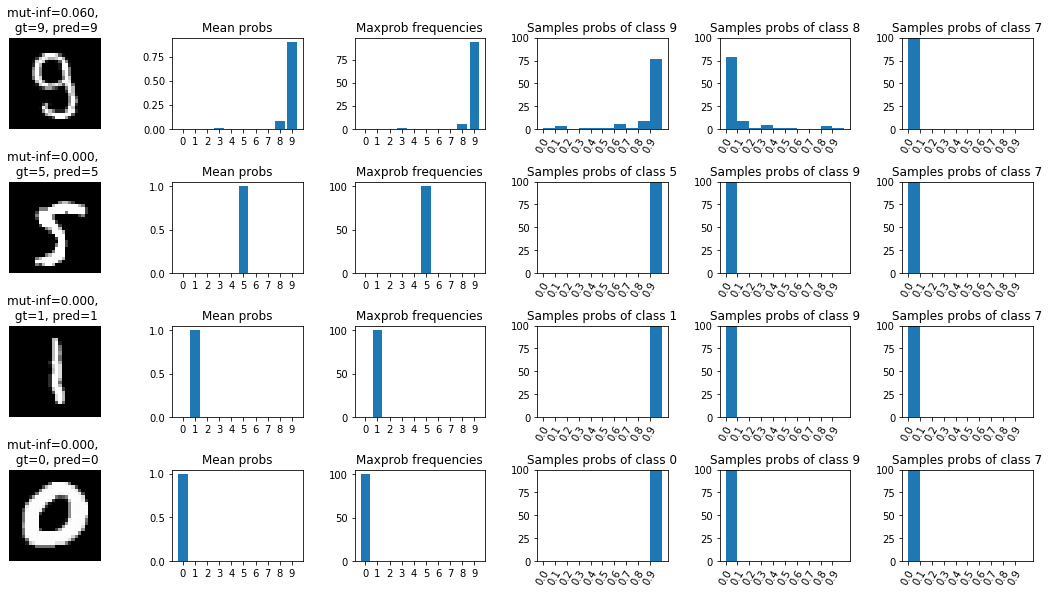

In [0]:
#TODO: as in previous code cell, visualize some random images here to help you compare. 
top_random_uncertain_samples = np.random.choice(range(len(uncertainty_var)), 4)
plot_predicted_images(top_random_uncertain_samples, test_loader.dataset.data, pred_var, labels, uncertainty_var, hists, mc_samples)

## Part II: Failure prediction

The objective is to provide confidence measures for model’s predictions that are reliable and whoseranking among samples enables to distinguish correct from incorrect predictions. Equipped with sucha confidence measure, a system could decide to stick to the prediction or, on the contrary, to handover to a human or a back-up system with,e.g.other sensors, or simply to trigger an alarm.

<div>
<img src="attachment:failure_prediction.png" width="500"/>
</div>

We will study in this section how each uncertainty estimate along with MCDropout compare between each others.

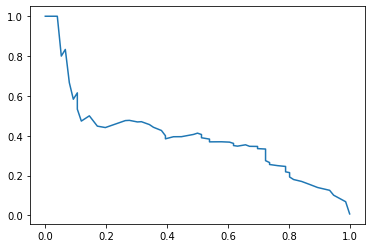

In [0]:
# Obtaining precision and recall plot vector + AUPR for previous MC Dropout with var-ratios
aupr_e_var = average_precision_score(errors_var, uncertainty_var)
precision_var, recall_var, _ = precision_recall_curve(errors_var, uncertainty_var)

**Question 2.1: Compute predictions in MCdropout mode with entropy, then obtain their precision and recall plot vector and aupr value that will be used in a plot later.**

Test set accuracy = 99.29%


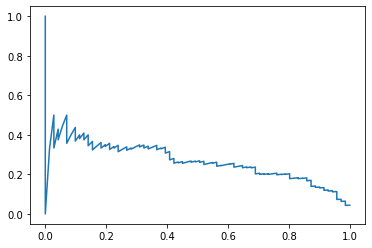

In [0]:
# TO DO: predictions in MCdropout mode with entropy, then obtain their precision and recall plot vector + aupr
pred_var, labels, uncertainty_var, errors_var, \
    hists, mc_samples = predict_test_set(lenet, test_loader, mode='entropy')
aupr_e_var_ent = average_precision_score(errors_var, uncertainty_var)
precision_var_ent, recall_var_ent, _ = precision_recall_curve(errors_var, uncertainty_var)

**Question 2.2: Same for MCdropout with mutual information.**

In [0]:
# TO DO: predictions in MCdropout mode with MI, then obtain their precision and recall plot vector + aupr
pred_var, labels, uncertainty_var, errors_var, \
    hists, mc_samples = predict_test_set(lenet, test_loader, mode='mi')
aupr_e_var_mi = average_precision_score(np.nan_to_num(errors_var), np.nan_to_num(uncertainty_var))

precision_var_mi, recall_var_mi, _ = precision_recall_curve(np.nan_to_num(errors_var), np.nan_to_num(uncertainty_var))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:74: RuntimeWarning: divide by zero encountered in log


Test set accuracy = 99.20%


**Question 2.2: Plot and compare the precision-recall curves of each method along with their AUPR values.**

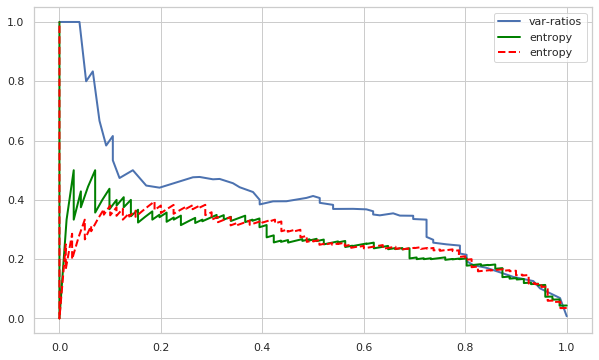

In [0]:
# TO DO: plot and compare the precision-recall curves of each method
import seaborn as sns; sns.set()
sns.set_style('whitegrid')
fig, ax = plt.subplots(figsize=(10, 6))
ax = plt.plot(recall_var, precision_var, linewidth=2, label='var-ratios')
ax = plt.plot(recall_var_ent, precision_var_ent, linewidth=2, color='green', label='entropy')
ax = plt.plot(recall_var_mi, precision_var_mi, linewidth=2, color='red', linestyle='--', label='entropy')
plt.legend()
plt.show()

## Part III: Out-of-distribution detection

Modern neural networks are known to generalize well when the training and testing data are sampled from the same distribution. However, when deploying neural networks in real-world applications, there is often very little control over the testing data distribution. It is important for classifiers to be aware of uncertainty when shown new kinds of inputs, i.e., out-of- distribution examples. Therefore, being able to accurately detect out-of-distribution examples can be practically important for visual recognition tasks.

<div>
<img src="attachment:motivation_1.PNG" width="500"/>
 Out-of-distribution example: Given a model trained with several pictures of dog breeds, a user ask the model to decide on a dog breed using a photo of a cat
</div>

In this section, we will use Kuzushiji-MNIST, a drop-in replacement for the MNIST dataset (28x28 grayscale, 70,000 images) containing 3832 Kanji (japanese) characters, as out-of-distribution sample to our model trained on MNIST. We will compare the methods for uncertainty estimates used previously and ODIN. 

In [0]:
# Load KMNIST dataset
kmnist_test_dataset = datasets.KMNIST('data', train=False, download=True, transform=transform)
kmnist_test_loader = DataLoader(kmnist_test_dataset, batch_size=128)

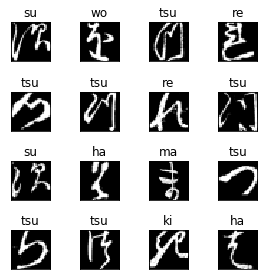

In [0]:
# Visualize some images
images, labels = next(iter(kmnist_test_loader))
fig, axes = plt.subplots(nrows=4, ncols=4)
for i, (image, label) in enumerate(zip(images, labels)):
    if i >= 16:
        break
    axes[i // 4][i % 4].imshow(images[i][0], cmap='gray')
    axes[i // 4][i % 4].set_title(f"{kmnist_test_dataset.classes[label]}")
    axes[i // 4][i % 4].set_xticks([])
    axes[i // 4][i % 4].set_yticks([])
fig.set_size_inches(4, 4)
fig.tight_layout()

In [0]:
# Compute predictions for MCP method on MNIST
_, _, uncertainty_mcp, errors_mcp, _, _ = predict_test_set(lenet, test_loader, mode='mcp')

# Compute predictions for MCP method on KMNIST
_, _, uncertainty_kmnist, errors_kmnist, _, _ = predict_test_set(lenet, kmnist_test_loader, mode='mcp')

# Concatenating predictions with MNIST, considering KMNIST samples as out-of-distributions
tot_uncertainty = np.concatenate((uncertainty_mcp, uncertainty_kmnist))
in_distribution = np.concatenate((np.zeros_like(uncertainty_mcp), np.ones_like(uncertainty_kmnist)))

# Obtaining precision and recall plot vector + AUPR
precision_ood_mcp, recall_ood_mcp, _ = precision_recall_curve(in_distribution, -tot_uncertainty)
aupr_ood_mcp = average_precision_score(in_distribution, -tot_uncertainty)

Test set accuracy = 98.61%


Test set accuracy = 8.71%


**Question 3.1: Compute predictions for MC Dropout with mutual-informations on KMNIST, then obtain their precision and recall plot vector and aupr value that will be used in a plot later.** 

In [0]:
# TO DO: compute predictions for MC Dropout with mutual information on KMNIST, 
# then obtain their precision and recall plot vector + aupr
pred_var, labels, uncertainty_var, errors_var, \
    hists, mc_samples = predict_test_set(lenet, kmnist_test_loader, mode='mi')
k_aupr_e_var_mi = average_precision_score(np.nan_to_num(errors_var), np.nan_to_num(uncertainty_var))

k_precision_var_mi, k_recall_var_mi, _ = precision_recall_curve(np.nan_to_num(errors_var), np.nan_to_num(uncertainty_var))

Test set accuracy = 8.65%


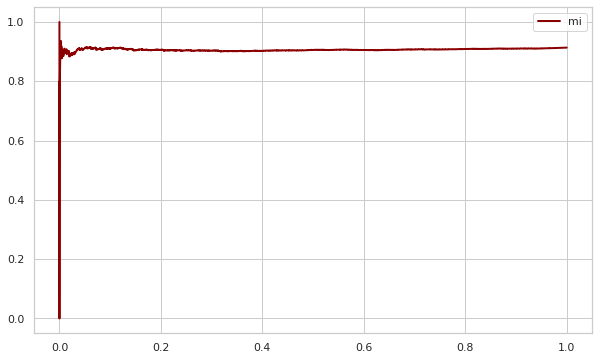

In [0]:
import seaborn as sns; sns.set()
sns.set_style('whitegrid')
fig, ax = plt.subplots(figsize=(10, 6))
ax = plt.plot(k_recall_var_mi, k_precision_var_mi, linewidth=2, color='darkred', label='mi')
plt.legend()
plt.show()

We will now implement the ODIN method.

ODIN [[Liang et al., ICLR 2018](https://openreview.net/pdf?id=H1VGkIxRZ)], is a threshold-based detector enhancing maximum softmax probabilities with two extensions:
- **temperature scaling**: 
	$ \textit{p}(y= c \vert \mathbf{x}, \mathbf{w}, T) = \frac{\exp(f_c( \mathbf{x}, \mathbf{w}) / T)}{\sum_{k=1}^K \exp(f_k( \mathbf{x}, \mathbf{w}) / T)} $
where $T \in \mathbb{R}^{+}$
- **inverse adversarial perturbation**: $ \tilde{\mathbf{x}} = \mathbf{x} - \epsilon \mathrm{sign} \big ( - \nabla_x \log (\textit{p}(y = y^* \vert \mathbf{x}, \mathbf{w}, T) \big ) $

Both technics aimed to increase in-distribution MCP higher than out-distribution MCP. Here, we set the hyperparameters $T=5$ and $\epsilon=0,14$.

**Question 3.2: Back to the `predict_test_set()` function implemented earlier, implement the ODIN method. You can test it with the following code.** 

In [0]:
# Compute predictions for ODIN on MNIST
_, _, uncertainty_odin, errors_odin, _, _ = predict_test_set(lenet, test_loader, mode='odin')

# Compute predictions for ODIN on KMNIST
_, _, uncertainty_kmnist, errors_kmnist, _, _ = predict_test_set(lenet, kmnist_test_loader, mode='odin')

# Concatenating predictions with MNIST, considering KMNIST samples as out-of-distributions
tot_uncertainty = np.concatenate((uncertainty_odin, uncertainty_kmnist))
in_distribution = np.concatenate((np.zeros_like(uncertainty_odin), np.ones_like(uncertainty_kmnist)))

# Obtaining precision and recall plot vector + AUPR
precision_ood_odin, recall_ood_odin, _ = precision_recall_curve(in_distribution, -tot_uncertainty)
aupr_ood_odin = average_precision_score(in_distribution, -tot_uncertainty)

**Question 3.3: Plot and compare the precision-recall curves of each OOD method along with their AUPR values. Which method perform best?**

In [0]:
# TO DO: plot and compare the precision-recall curves of each OOD method